## Why embedding??                                            
### 1.deal with the curse of dimensionality: 
For example, if one wants to model the joint distribution of 10
consecutive words in a natural language with a vocabulary V of size 100,000, there are potentially
100000^10 − 1 = 10^50 − 1 free parameters
### 2.better generalization: 
it will so generalize because “similar” words are expected to have a similar feature vector, and because the probability function is a smooth function of these feature values, a small change in the features will induce a small change in the probability. Therefore, the presence of only one of the above sentences in the training data will increase the probability, not only of that sentence, but also of its combinatorial number of “neighbors” in sentence space (as represented by sequences of feature vectors).

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
words=open('C:\\Users\\Administrator\\Desktop\\NN\\Python\\name.txt','r').read().splitlines()

In [4]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
len(''.join(words))

196113

In [8]:
#bulid the dataset

def build_dataset(words):
    block_size=3   # context length: how many characters do we take to predict the next one?
    X,Y=[],[]
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])   #training split 80%
Xdev, Ydev = build_dataset(words[n1:n2])   #dev/validation split 10%
Xte, Yte = build_dataset(words[n2:])    #test split 10%
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [19]:
X,Y=build_dataset(words[:5])
X.shape, X.dtype, Y.shape, Y.dtype

torch.Size([36, 3]) torch.Size([36])


(torch.Size([36, 3]), torch.int64, torch.Size([36]), torch.int64)

In [15]:
C=torch.randn((27,2))   #27 is the total characters, 2 is a hyperparameter, the dimension of embedding

In [16]:
C[5] #extract a row from the embedding lookup table(C)

tensor([-0.0311, -0.1023])

In [17]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C #seen as a hidden layer of the whole nn,equivalent with the line above

tensor([-0.0311, -0.1023])

In [20]:
C[X].shape

torch.Size([36, 3, 2])

In [21]:
X[13,2]

tensor(18)

In [22]:
C[X][13,2]

tensor([ 0.7488, -1.0118])

In [23]:
C[1]

tensor([-0.4438,  0.7194])

In [24]:
emb = C[X]
emb.shape

torch.Size([36, 3, 2])

In [26]:
emb=C[X]

In [28]:
emb[:,0,:]

tensor([[ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [-0.6749,  0.3526],
        [-0.0889,  1.0340],
        [-0.8589,  0.9289],
        [-0.0311, -0.1023],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.0479,  1.0276],
        [ 0.7298,  1.0243],
        [-1.7073, -0.6008],
        [ 0.4205, -0.9407],
        [ 0.0479,  1.0276],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [-0.5027,  0.0653],
        [-0.4438,  0.7194],
        [ 0.2271, -1.9460],
        [ 0.7298,  1.0243],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.3536, -0.0820],
        [-1.7073, -0.6008],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.9024,  0.4961],
        [ 0.3536, -0.0820],
        [-0.0889,  1.0340],
        [-0.4438,  0.7194],
        [ 0.4205, -0.9407],
        [ 0.2439, -1.5849],
        [-0.0889,  1

In [16]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [21]:
#we need to change the dimension of emb to (32,6)
#torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape
torch.cat(torch.unbind(emb,1),1).shape    
#it is inefficient,cost new memory

torch.Size([32, 6])

In [24]:
#more efficient way
emb.view(32,6) == torch.cat(torch.unbind(emb,1),1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [18]:
h.shape

torch.Size([32, 100])

In [19]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2 + b2

In [21]:
logits.shape

torch.Size([32, 27])

In [22]:
counts = logits.exp()

In [23]:
prob = counts / counts.sum(1, keepdims=True)

In [24]:
prob.shape

torch.Size([32, 27])

In [25]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.7986)

loss直接用F.cross_entropy求更好：\
1.make forward pass more efficient (不占内存）\
2.make backward pass more efficient （simplier expression 与之前定义的tanh()同理)\
3.numerically well behaved(存在极端值的情况时会减掉一个常数值使得输出不会出现inf的情况)

In [26]:
# ------------ now made respectable :) ---------------

In [17]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [31]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [32]:
for p in parameters:
    p.requires_grad = True

In [33]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre  #exponently between 0.001 and 1

In [32]:
lri = []
lossi = []
stepi = []

In [33]:
for i in range(1000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  
    # 32 is a hyperparameter,the size of each minibatch,it chould be tuned to get the best performance

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None  #don't forget this
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

#print(loss.item())

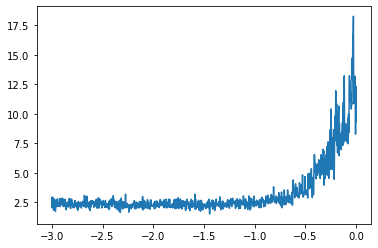

In [35]:
plt.plot(lri,lossi)  #得到大致的learning rate

In [51]:
lri = []
lossi = []
stepi = []

for i in range(20000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  
    # 32 is a hyperparameter,the size of each minibatch,it chould be tuned to get the best performance

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None  #don't forget this
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01  #learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.272260904312134


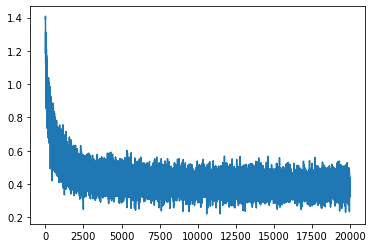

In [52]:
plt.plot(stepi, lossi)

minibatch create noise

In [53]:
#the loss of training split
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4447, grad_fn=<NllLossBackward0>)

In [54]:
#the loss of dev split
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4528, grad_fn=<NllLossBackward0>)

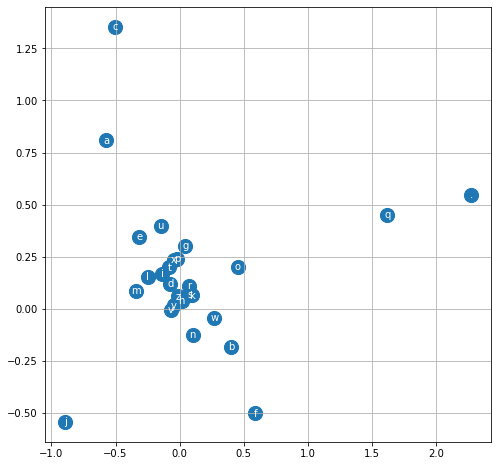

In [28]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

eria.
kayah.
keel.
nahlyal.
rethrej.
kerleo.
azereon.
liighliopelle.
elissonnarielle.
malara.
nysalgorg.
hiriel.
ken.
renellonnton.
founa.
ted.
ryyahleyeksylar.
mysalyanahil.
salyansuf.
zakelle.


Notes:\
1.增加hidden layers and neuros 使得这里有更多的parameter， 一直添加会make NN more capable of overfitting， the loss of training set can be as low as zero,这个时候the loss of 某些袋外数据可以be very high\
2.when the loss of training set and the loss of dev set are roughly equal,此时不存在overfiting，而且可能存在underfitting，这说明thethe number of parameters is very small(compared with the sample size)，这不是我们想要的情况，我们应该增加parameters的数量（等其他tuning操作）使得loss_tr和loss_dev区别变大，我们想要的是loss_tr and loss_dev start to slightly slowly depart，这个时候说明模型is good enough, the number of parameters is large enough,that it starts to slowly overfitting，模型能够较好的处理training set的信息，但不至于太overfitting。\
3.dev split is used to tune the hyperparameters, including he number of previous characters as context,the numner of embeddings, the number of layers, the number of neuros,the size of minibatch;  learning rate, iteration number...to achieve a better convergence speed,calculation time and low loss........(比如C的embedding dimension（上面最开始设置的是2） 太小了话可能会限制NN的performance上限） (再比如如果minibatch太小的话gradient波动会较大且不准确）......在dev split中对装有所有hyperparameters的set进行一系列的experiment,找到最好的组合，最后放test set 中，其结果用于报告